<a href="https://colab.research.google.com/github/santacruzAI/MLPhasesOfMatter/blob/main/Clean_Machine_Learning_Phase_Transitions_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**FOR WORKING PURPOSES ONLY:**

Plan:

1. Generate Square Lattice Data
2. Create a Fully-Conected Neural Network, achieving 94% accuracy on 10x10 grids.
3. Create a Fully Connected Neural Network, achieving 99% accuracy on 40x40 grids.
4. Create the mentioned Toy Model, with analytically determined parameters.
5. Generate Triangular Lattice Data (L = 30) *(Side Note: They don't seem to train a separate model for each L)*
6. If necessary, train a Fully Connected Neural Network on 30x30 square lattice data.
7. Test out Fully Connected Neural Network on the Triangular Lattice Data.
8. Generate Square Ice Lattice Data (2 x 16 x 16).
9. Train Fully Connected Neural Network on Square Ice Lattice Data (100 hidden units..)
10. Generate Ising Lattice Gauge Theory Lattices (16 x 16 x 2).
11. Train a Fully-Connected Neural Network on this data, show it only attains 50% accuracy.
12. Train a ConvNet on this data, show it attains nearly 100% accuracy.
13. Modify the testing set to violate the closed-loop structure.
14. Test the ConvNet on this, demonstrate results are still high.
15. Modify the testing set to violate locality constraints.
16. Test the ConvNet on this, demonstrate results are lower.
17. Discuss future extensions, and eventually start implementing them.


In [1]:
import numpy as np
import random
!pip install numba
from numba import jit
import matplotlib.pyplot as plt
!pip install tqdm
!pip install ray
from tqdm import tqdm
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54.5 MB 207 kB/s 
     |████████████████████████████████| 4.1 MB 45.5 MB/s 
     |████████████████████████████████| 8.8 MB 44.6 MB/s 
     |████████████████████████████████| 466 kB 56.9 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.47.0
    Uninstalling grpcio-1.47.0:
      Successfully uninstalled grpcio-1.47.0


# **Data Generation**

In [2]:
np.random.seed(seed = 3)

Here, we will perform the Metropolis-Hastings Algorithm to generate square lattices.

First, we create this function to calculate the square Hamiltonian for each lattice.

In [3]:
@jit
def ferr_square_energy(lattice):
  en = 0
  for i in range(len(lattice)):
    for j in range(len(lattice)):
      if i>0:
        en += lattice[i][j]*lattice[i-1][j]
      if i<len(lattice)-1:
        en += lattice[i][j]*lattice[i+1][j]
      if j>0:
        en += lattice[i][j]*lattice[i][j-1]
      if j<len(lattice)-1:
        en += lattice[i][j] * lattice[i][j+1]
  return en

Here, we initialize our constants.

In [4]:
k = (1.38064852)/(10**23) #

Now, we create a function to execute the Metropolis-Hastings Algorithm and collect samples.

In [5]:
from typing import Callable
def metropolis(get_energy: Callable[[np.ndarray], float], grid_size: int, starts: int, samples: int, temp_start: float, temp_end: float, therm_steps: int):
  temp_range = np.linspace(temp_start,temp_end,int(10*(temp_end-temp_start))) #The range of temperatures from 1 to 3.7
  tempList = [] #This collects the specific temperatures for later plotting.
  sampleList = [] #This collects the samples over the Metropolis-Hastings algorithm.

  #For each temperature, for each start, we collect samples collected after thermal evolution. 
  for temp_count in tqdm(range(len(temp_range))):
    temp = temp_range[temp_count]
    #Computing beta.
    b = 1/(k*temp) 
    #Collect each sample.
    for sample in range(samples): 
      #Generates a random lattice of decimals between -1 and 1.
      lattice = np.array([random.choice([-1, 1]) for j in range(grid_size**2)]).reshape(grid_size, grid_size)
      
      #This collects all the energies of samples for plotting.
      enList = [] 
      #Here, we will collect iterative times for plotting.
      timeList = []
      #Initializing algorithmic time to 0.
      time = 0
    
      #We perform thermal evolution.
      for therm_step in range(therm_steps):
      
        #Collect the energy of the current lattice.
        curr_en = get_energy(lattice)
        
        #Picks a lattice sites to flip.
        index = random.randint(0, (grid_size - 1) * (grid_size - 1))
        flip_x, flip_y = (index//grid_size, index % grid_size)

        flip_row = index//grid_size
        
        #We create a candidate state (state_v) that has this site flipped. 
        state_v = lattice.copy()
        #state_v[flip_x][flip_y] *=-1
        state_v[flip_row] *= -1

        #Here, we evaluate the energy of this candidate.
        v_en = get_energy(state_v)
      
        #Now we calculate the probability that this state will be accepted. If the candidate state has a lower energy than the current state, this probability is 1, else it is the exponentiation of the difference between the candidate and present energy scaled.
        p_uv = 1 if v_en < curr_en else np.exp(-b*(v_en - curr_en))
      
        #We store the algorithmic time and increment it.
        timeList.append(time)
        time += 1
      
        #If a coin toss with this acceptance probability as its distribution produces a 1 (perhaps thought of as a heads), we accept the state.
        if np.random.uniform()<=p_uv:
        #if np.random.uniform() < np.exp()
          lattice = state_v.copy()
      
        #We store the energy of the lattice, for the plotting.
        enList.append(get_energy(lattice))
    
      #Here we store the sample and the current temperature for plotting and sample collection.
      sampleList.append(lattice)
      tempList.append(temp)
        
  return sampleList, tempList, enList, timeList

Now we run Metropolis-Hastings for the Square Lattice to generate 10 x 10 lattices, over 10 starts, taking 100 samples per start per temperatures ranging between 1.0 and 3.7. 100 thermal evolution steps will be taken to simulate the effects of a thermal bath.

In [6]:
sampleList, tempList, enList, timeList = metropolis(ferr_square_energy, 10, 10, 100, 1, 3.7, 100)

100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


**Here, we plot algorithmic time vs the energy of the lattices over the last iteration of thermal evolution in the Metropolis-Hastings Algorithm.**

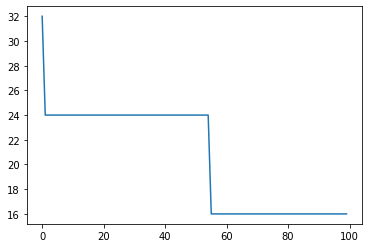

In [7]:
#We plot energy vs algorithmic time.
plt.plot(timeList, enList)

Though it is roughly-hewn, and may appear jittery, the energy decreases consistently over time, which is encouraging.

## **Data Preprocessing**

**Here we preprocess the data by simply flattening the lattices into feature vectors, perform train-test split and store it in a .csv file.**




In [ ]:
def train_test_data(sampleList):

  #Here, we flatten the samples into a feature matrix.
  feature_matrix = np.array([features.flatten() for features in sampleList])
  
  #Set Curie Temperature as 2.27
  Tc = 2.27
  
  #We create another set of temperature values, first reformatting to correct dimensions and marking all temperatures above the critical temperature 1, and all below 0.
  tempList2 = np.array([[temp] for temp in tempList])
  tempList3 = np.zeros(tempList2.shape)
  tempList3[tempList2>=Tc] = 1
  tempList3[tempList2<Tc] = 0
  
  #Now, we append the target column (1/0 to indicate temp above or below the critical temperature) to the feature matrix.
  feature_matrix = np.append(feature_matrix, tempList3, axis = 1)
  
  #We shuffle the feature matrix so that the neural network doesn't pick up any pattern around the temperature-ordered way we generated the data.
  np.random.shuffle(feature_matrix) #

  #Here, we perform train-test split, and pick 3/5 of the data for training and 2/5 for testing.
  end = 4 * len(feature_matrix) // 5
  feature_train_matrix = feature_matrix[:end, :-1]
  feature_test_matrix = feature_matrix[end:, :-1]
  
  tempList2 = feature_matrix[:,-1]
  tempList2 = [int(temp) for temp in tempList2]
  
  y_train = tempList2[:end]
  y_test = tempList2[end:]
 
  #Here, we return the training and testing data.
  
  return feature_train_matrix, np.expand_dims(np.array(y_train), axis = 1), feature_test_matrix, np.expand_dims(np.array(y_test), axis = 1)

feature_train_matrix, y_train, feature_test_matrix, y_test = train_test_data(sampleList)

#Uncomment the code below to store the data into a csv file.

#csv_train = pd.DataFrame(feature_train_matrix)
#csv_train["y_train"] = y_train
#csv_train = csv_train.to_csv("square_csv_train.csv")
#csv_test = pd.DataFrame(feature_test_matrix)
#csv_test["y_test"] = y_test
#csv_test = csv_test.to_csv("square_csv_test.csv")

#These lines of code can be uncommented to download the csv files.

#from google.colab import files
#files.download("csv_train.csv")
#files.download("csv_test.csv")

##**Hyperparameter Tuning**

## **Feedforward Neural Network for Square Lattice Phase Transitions**

**Here, we construct our first Neural Network.**

Here we create a class defining a LinearModel Neural Network with dimensions as specified in paper, input layer of grid_size * grid_size x 100 and a hidden layer of 100 x 2, including a non-linear sigmoid activation.

In [9]:
import torch.nn as nn #Super-class for PyTorch NNs
from torch.nn import Sigmoid
from torch.optim import Adam
import torch
from torch import Tensor
from torch import from_numpy
grid_size = 10
class LinearModel(nn.Module): 
    def __init__(self): #Define struct
        super(LinearModel, self).__init__()          
        self.fc_1 = nn.Linear(grid_size*grid_size, 100)    
        self.fc_2 = nn.Linear(100, 2)
            
    def forward(self, X):    
        output = self.fc_1(X)
        output = nn.Sigmoid()(output)
        output = self.fc_2(output)
        output = nn.Sigmoid()(output)
        return output

**Training:**

Here we train the model on the training data using Cross-Entropy Loss with Adam-based optimization.

In [10]:
temptest = [0 if temp < 2.27 else 1 for temp in tempList]
print(temptest.count(0))
print(temptest.count(1))

1300
1400


In [11]:
def flip(n):
  if n == 1:
    return 0
  else:
    return 1

In [12]:
train_features = feature_train_matrix.copy()
train_out = y_train.copy()
optalg = Adam
epochs = 1000
batch_size = 128
feature_test_matrix_torch = torch.Tensor(feature_test_matrix)
y_test_torch = torch.Tensor(y_test).type(torch.LongTensor)

features_train = train_features.copy()
target_train = train_out.copy()
#The grid_size is merely the square root of the length of each example, since its features are the list of all lattice sites.
grid_size = int(np.sqrt(len(features_train[0])))

#We run some number of Epochs of training.
EPOCHS = epochs

#Here we instantiate a Linear Model and set it to train mode.
model = LinearModel()
model.train()

#We set the criterion to be CrossEntropyLoss and the optimizer Adam.
criterion = nn.BCELoss()
optimizer = optalg(model.parameters(), lr = 10**-5)

#We convert the numpy data to a PyTorch Tensor to be compatible with the neural network.
y_train_torch = torch.from_numpy(target_train)
y_train_torch = y_train_torch.type(torch.LongTensor)
feature_train_matrix_torch = torch.from_numpy(features_train)

#Initialize the list of accuracies for plotting purposes.
acc_list = []
test_acc_list = []
#Initialize the list of epochs for plotting purposes.
ep_li = []
predictions = []

#For each epoch
for ep in tqdm(range(1, EPOCHS + 1)):
  acc = 0
  ep_li.append(ep)
  rand_perms = torch.randperm(feature_train_matrix_torch.shape[0])
  
  #for each training example, extract the example's features, set the optimizer to zero_gradient mode.

  for i in range(0, rand_perms.shape[0], batch_size):
    current_indices = rand_perms[i:i+batch_size]
    current_features = feature_train_matrix_torch[current_indices].type(torch.FloatTensor)
    current_targets = y_train_torch[current_indices].type(torch.LongTensor)
    optimizer.zero_grad()

    out = model.forward(current_features)
    #print("OUT.SHAPE: ", out.shape)
    label = nn.functional.one_hot(current_targets.type(torch.LongTensor), num_classes = 2).type(torch.FloatTensor).squeeze(1)
    
    #print("LABEL.SHAPE: ", label.shape)
    #print("OUT.SHAPE: ", out.shape)
    #print("\nCurrent Features Shape: ", current_features.shape)
    #print("Current Targets Shape: ", current_targets.shape)
    
    acc+= list(torch.argmax(label, 1) - torch.argmax(out, 1)).count(0)
    #if(torch.eq(torch.argmax(label,1), torch.argmax(out_hot,1)).all()):
    #  acc+=1
    #Calculate the loss via cross entropy.
    loss = criterion(out,label)
    #Perform backward propagation to improve the weights, on this loss function.
    loss.backward()
    #Step the optimizer.
    optimizer.step()
  
  #Testing Step

  test_out = model.forward(feature_test_matrix_torch)
  test_label = nn.functional.one_hot(y_test_torch.type(torch.LongTensor), num_classes = 2).type(torch.FloatTensor).squeeze(1)
  test_acc = list(torch.argmax(test_label, 1) - torch.argmax(test_out, 1)).count(0)

  print("\nTRAIN ACCURACY: ", 100 * acc/len(y_train_torch))
  print("TEST ACCURACY: ", 100* test_acc/len(y_test_torch))

  acc_list.append(100*acc/len(y_train_torch))
  test_acc_list.append(100*test_acc/len(y_test_torch))
  ep_li.append(ep)

  0%|          | 3/1000 [00:00<02:04,  7.98it/s]


TRAIN ACCURACY:  46.898148148148145
TEST ACCURACY:  47.77777777777778

TRAIN ACCURACY:  46.898148148148145
TEST ACCURACY:  47.96296296296296

TRAIN ACCURACY:  47.03703703703704
TEST ACCURACY:  46.851851851851855


  1%|          | 7/1000 [00:00<01:20, 12.26it/s]


TRAIN ACCURACY:  47.083333333333336
TEST ACCURACY:  48.148148148148145

TRAIN ACCURACY:  47.129629629629626
TEST ACCURACY:  47.22222222222222

TRAIN ACCURACY:  47.407407407407405
TEST ACCURACY:  47.407407407407405

TRAIN ACCURACY:  47.68518518518518
TEST ACCURACY:  47.03703703703704


  1%|          | 9/1000 [00:00<01:20, 12.27it/s]


TRAIN ACCURACY:  47.73148148148148
TEST ACCURACY:  46.111111111111114

TRAIN ACCURACY:  47.916666666666664
TEST ACCURACY:  46.111111111111114


  1%|          | 11/1000 [00:01<01:25, 11.52it/s]


TRAIN ACCURACY:  48.333333333333336
TEST ACCURACY:  46.2962962962963

TRAIN ACCURACY:  48.657407407407405
TEST ACCURACY:  46.48148148148148


  1%|▏         | 13/1000 [00:01<01:33, 10.54it/s]


TRAIN ACCURACY:  48.425925925925924
TEST ACCURACY:  47.77777777777778

TRAIN ACCURACY:  48.19444444444444
TEST ACCURACY:  47.592592592592595

TRAIN ACCURACY:  48.611111111111114
TEST ACCURACY:  48.333333333333336


  2%|▏         | 17/1000 [00:01<01:28, 11.13it/s]


TRAIN ACCURACY:  48.7962962962963
TEST ACCURACY:  48.7037037037037

TRAIN ACCURACY:  49.44444444444444
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  49.9537037037037
TEST ACCURACY:  49.44444444444444


  2%|▏         | 19/1000 [00:01<01:24, 11.62it/s]


TRAIN ACCURACY:  50.0
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  50.416666666666664
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  50.27777777777778
TEST ACCURACY:  49.81481481481482


  2%|▏         | 23/1000 [00:02<01:25, 11.46it/s]


TRAIN ACCURACY:  50.0
TEST ACCURACY:  50.0

TRAIN ACCURACY:  49.907407407407405
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  49.675925925925924
TEST ACCURACY:  50.0


  2%|▎         | 25/1000 [00:02<01:28, 11.06it/s]


TRAIN ACCURACY:  49.72222222222222
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  49.49074074074074
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  49.76851851851852
TEST ACCURACY:  50.55555555555556


  3%|▎         | 27/1000 [00:02<01:23, 11.66it/s]


TRAIN ACCURACY:  49.76851851851852
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  49.629629629629626
TEST ACCURACY:  50.55555555555556


  3%|▎         | 31/1000 [00:02<01:21, 11.84it/s]


TRAIN ACCURACY:  49.81481481481482
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  49.9537037037037
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  50.27777777777778
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  50.50925925925926
TEST ACCURACY:  50.55555555555556


  4%|▎         | 35/1000 [00:03<01:13, 13.18it/s]


TRAIN ACCURACY:  50.416666666666664
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  50.74074074074074
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  50.97222222222222
TEST ACCURACY:  51.111111111111114


  4%|▎         | 37/1000 [00:03<01:09, 13.77it/s]


TRAIN ACCURACY:  51.157407407407405
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  50.925925925925924
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  51.01851851851852
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  51.25
TEST ACCURACY:  50.74074074074074


  4%|▍         | 41/1000 [00:03<01:15, 12.67it/s]


TRAIN ACCURACY:  51.2037037037037
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  51.342592592592595
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  51.2962962962963
TEST ACCURACY:  49.81481481481482


  4%|▍         | 45/1000 [00:03<01:20, 11.85it/s]


TRAIN ACCURACY:  51.43518518518518
TEST ACCURACY:  50.0

TRAIN ACCURACY:  51.574074074074076
TEST ACCURACY:  50.0

TRAIN ACCURACY:  51.80555555555556
TEST ACCURACY:  49.629629629629626


  5%|▍         | 47/1000 [00:04<01:19, 11.96it/s]


TRAIN ACCURACY:  51.75925925925926
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  51.574074074074076
TEST ACCURACY:  50.0

TRAIN ACCURACY:  51.71296296296296
TEST ACCURACY:  50.370370370370374


  5%|▌         | 51/1000 [00:04<01:15, 12.63it/s]


TRAIN ACCURACY:  51.80555555555556
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  51.94444444444444
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  51.75925925925926
TEST ACCURACY:  50.18518518518518


  5%|▌         | 53/1000 [00:04<01:12, 13.09it/s]


TRAIN ACCURACY:  51.851851851851855
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  51.80555555555556
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  51.80555555555556
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  51.99074074074074

  6%|▌         | 57/1000 [00:04<01:17, 12.23it/s]


TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  51.898148148148145
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  51.851851851851855
TEST ACCURACY:  51.48148148148148


  6%|▌         | 59/1000 [00:05<01:31, 10.27it/s]


TRAIN ACCURACY:  51.75925925925926
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  51.851851851851855
TEST ACCURACY:  50.74074074074074


  6%|▌         | 61/1000 [00:05<01:33, 10.04it/s]


TRAIN ACCURACY:  51.80555555555556
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  51.99074074074074
TEST ACCURACY:  51.2962962962963


  6%|▋         | 63/1000 [00:05<01:34,  9.88it/s]


TRAIN ACCURACY:  51.851851851851855
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  51.99074074074074
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  52.22222222222222
TEST ACCURACY:  

  6%|▋         | 65/1000 [00:05<01:42,  9.08it/s]

51.851851851851855

TRAIN ACCURACY:  52.31481481481482
TEST ACCURACY:  52.03703703703704


  7%|▋         | 68/1000 [00:06<01:26, 10.75it/s]


TRAIN ACCURACY:  52.26851851851852
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  52.4537037037037
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  52.4537037037037
TEST ACCURACY:  51.851851851851855


  7%|▋         | 70/1000 [00:06<01:21, 11.38it/s]


TRAIN ACCURACY:  52.4537037037037
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  52.638888888888886
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  52.407407407407405
TEST ACCURACY:  51.666666666666664


  7%|▋         | 74/1000 [00:06<01:15, 12.25it/s]


TRAIN ACCURACY:  52.5462962962963
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  52.4537037037037
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  52.5462962962963
TEST ACCURACY:  51.666666666666664


  8%|▊         | 76/1000 [00:06<01:11, 12.92it/s]


TRAIN ACCURACY:  52.5462962962963
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  52.4537037037037
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  52.592592592592595
TEST ACCURACY:  51.48148148148148


  8%|▊         | 78/1000 [00:06<01:11, 12.97it/s]


TRAIN ACCURACY:  52.5462962962963
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  52.592592592592595
TEST ACCURACY:  51.48148148148148


  8%|▊         | 82/1000 [00:07<01:17, 11.82it/s]


TRAIN ACCURACY:  52.68518518518518
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  52.5462962962963
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  52.592592592592595
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  52.592592592592595
TEST ACCURACY:  51.48148148148148


  9%|▊         | 86/1000 [00:07<01:10, 12.91it/s]


TRAIN ACCURACY:  52.592592592592595
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  52.68518518518518
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  52.77777777777778
TEST ACCURACY:  51.2962962962963


  9%|▉         | 88/1000 [00:07<01:09, 13.16it/s]


TRAIN ACCURACY:  52.824074074074076
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  52.916666666666664
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  52.96296296296296
TEST ACCURACY:  51.851851851851855


  9%|▉         | 92/1000 [00:07<01:11, 12.68it/s]


TRAIN ACCURACY:  52.96296296296296
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  53.00925925925926
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  52.916666666666664
TEST ACCURACY:  51.851851851851855


  9%|▉         | 94/1000 [00:08<01:24, 10.73it/s]


TRAIN ACCURACY:  52.96296296296296
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  53.101851851851855
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  53.19444444444444
TEST ACCURACY:  51.851851851851855


 10%|▉         | 96/1000 [00:08<01:20, 11.23it/s]


TRAIN ACCURACY:  53.24074074074074
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  53.28703703703704
TEST ACCURACY:  51.851851851851855


 10%|▉         | 98/1000 [00:08<01:28, 10.21it/s]


TRAIN ACCURACY:  53.19444444444444
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  53.19444444444444
TEST ACCURACY:  51.851851851851855


 10%|█         | 102/1000 [00:08<01:27, 10.26it/s]


TRAIN ACCURACY:  53.101851851851855
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  53.101851851851855
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  53.05555555555556
TEST ACCURACY:  52.03703703703704


 10%|█         | 104/1000 [00:09<01:19, 11.23it/s]


TRAIN ACCURACY:  53.24074074074074
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  53.148148148148145
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  53.333333333333336
TEST ACCURACY:  52.22222222222222


 11%|█         | 106/1000 [00:09<01:28, 10.11it/s]


TRAIN ACCURACY:  53.19444444444444
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  53.24074074074074
TEST ACCURACY:  52.22222222222222


 11%|█         | 108/1000 [00:09<01:30,  9.90it/s]


TRAIN ACCURACY:  53.333333333333336
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  53.425925925925924
TEST ACCURACY:  52.407407407407405


 11%|█         | 112/1000 [00:09<01:32,  9.61it/s]


TRAIN ACCURACY:  53.47222222222222
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  53.51851851851852
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  53.47222222222222
TEST ACCURACY:  52.407407407407405


 11%|█▏        | 114/1000 [00:10<01:22, 10.72it/s]


TRAIN ACCURACY:  53.47222222222222
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  53.425925925925924
TEST ACCURACY:  52.03703703703704


 12%|█▏        | 116/1000 [00:10<01:30,  9.81it/s]


TRAIN ACCURACY:  53.611111111111114
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  53.425925925925924
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  53.56481481481482
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  53.51851851851852
TEST ACCURACY: 

 12%|█▏        | 120/1000 [00:10<01:25, 10.28it/s]

 51.2962962962963

TRAIN ACCURACY:  53.657407407407405
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  53.51851851851852
TEST ACCURACY:  51.666666666666664


 12%|█▏        | 122/1000 [00:10<01:31,  9.61it/s]


TRAIN ACCURACY:  53.51851851851852
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  53.611111111111114
TEST ACCURACY:  51.48148148148148


 12%|█▏        | 124/1000 [00:11<01:40,  8.71it/s]


TRAIN ACCURACY:  53.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  53.657407407407405
TEST ACCURACY:  51.666666666666664


 13%|█▎        | 126/1000 [00:11<01:37,  8.99it/s]


TRAIN ACCURACY:  53.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  53.7037037037037
TEST ACCURACY:  51.48148148148148


 13%|█▎        | 129/1000 [00:11<01:27,  9.97it/s]


TRAIN ACCURACY:  53.7037037037037
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  53.7962962962963
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  53.7962962962963
TEST ACCURACY:  51.48148148148148


 13%|█▎        | 132/1000 [00:12<01:27,  9.91it/s]


TRAIN ACCURACY:  53.7962962962963
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  53.7037037037037
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  53.75
TEST ACCURACY:  51.48148148148148


 14%|█▎        | 135/1000 [00:12<01:16, 11.32it/s]


TRAIN ACCURACY:  53.7962962962963
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  53.888888888888886
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  53.7037037037037
TEST ACCURACY:  51.2962962962963


 14%|█▎        | 137/1000 [00:12<01:11, 12.02it/s]


TRAIN ACCURACY:  53.7962962962963
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  53.842592592592595
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  53.7037037037037
TEST ACCURACY:  50.925925925925924


 14%|█▍        | 141/1000 [00:12<01:10, 12.15it/s]


TRAIN ACCURACY:  53.888888888888886
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  53.98148148148148
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  54.074074074074076
TEST ACCURACY:  51.111111111111114


 14%|█▍        | 143/1000 [00:12<01:16, 11.21it/s]


TRAIN ACCURACY:  54.074074074074076
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  54.120370370370374
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  54.25925925925926
TEST ACCURACY:  50.925925925925924


 15%|█▍        | 147/1000 [00:13<01:12, 11.74it/s]


TRAIN ACCURACY:  54.351851851851855
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  54.21296296296296
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  54.21296296296296
TEST ACCURACY:  50.925925925925924


 15%|█▌        | 152/1000 [00:13<00:54, 15.47it/s]


TRAIN ACCURACY:  54.21296296296296
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  54.25925925925926
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  54.351851851851855
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  54.49074074074074
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  54.53703703703704
TEST ACCURACY:  50.55555555555556


 16%|█▌        | 158/1000 [00:13<00:42, 19.78it/s]


TRAIN ACCURACY:  54.53703703703704
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  54.629629629629626
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.49074074074074
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  54.629629629629626
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  54.81481481481482
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  54.72222222222222
TEST ACCURACY:  50.370370370370374


 16%|█▋        | 164/1000 [00:14<00:37, 22.08it/s]


TRAIN ACCURACY:  54.72222222222222
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.861111111111114
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.907407407407405
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  55.0462962962963
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  55.0
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.9537037037037
TEST ACCURACY:  50.55555555555556


 17%|█▋        | 170/1000 [00:14<00:35, 23.09it/s]


TRAIN ACCURACY:  55.0462962962963
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.27777777777778
TEST ACCURACY:  50.0

TRAIN ACCURACY:  55.324074074074076
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.23148148148148
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.138888888888886
TEST ACCURACY:  50.0

TRAIN ACCURACY:  55.092592592592595
TEST ACCURACY:  50.0


 18%|█▊        | 176/1000 [00:14<00:34, 23.81it/s]


TRAIN ACCURACY:  55.46296296296296
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  55.416666666666664
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  55.27777777777778
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.27777777777778
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  55.138888888888886
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.092592592592595
TEST ACCURACY:  50.370370370370374


 18%|█▊        | 179/1000 [00:14<00:34, 24.02it/s]


TRAIN ACCURACY:  54.861111111111114
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.81481481481482
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.9537037037037
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  54.81481481481482
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.861111111111114
TEST ACCURACY:  50.370370370370374


 18%|█▊        | 185/1000 [00:14<00:33, 23.99it/s]


TRAIN ACCURACY:  54.861111111111114
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.81481481481482
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  54.81481481481482
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.76851851851852
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.72222222222222
TEST ACCURACY:  50.370370370370374


 19%|█▉        | 191/1000 [00:15<00:33, 24.24it/s]


TRAIN ACCURACY:  54.76851851851852
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.629629629629626
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  54.81481481481482
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.81481481481482
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.861111111111114
TEST ACCURACY:  50.55555555555556


 19%|█▉        | 194/1000 [00:15<00:33, 24.33it/s]


TRAIN ACCURACY:  54.81481481481482
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.861111111111114
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  54.861111111111114
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.9537037037037
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.9537037037037
TEST ACCURACY:  50.18518518518518


 20%|██        | 200/1000 [00:15<00:33, 23.89it/s]


TRAIN ACCURACY:  54.861111111111114
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.861111111111114
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.861111111111114
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  54.9537037037037
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  55.0
TEST ACCURACY:  50.55555555555556


 21%|██        | 206/1000 [00:15<00:33, 23.97it/s]


TRAIN ACCURACY:  55.0462962962963
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  55.0462962962963
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  55.0462962962963
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  55.138888888888886
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  55.092592592592595
TEST ACCURACY:  50.55555555555556


 21%|██        | 212/1000 [00:16<00:32, 24.00it/s]


TRAIN ACCURACY:  55.0462962962963
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  55.18518518518518
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  55.27777777777778
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  55.324074074074076
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  55.27777777777778
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  55.18518518518518
TEST ACCURACY:  50.18518518518518


 22%|██▏       | 218/1000 [00:16<00:32, 24.33it/s]


TRAIN ACCURACY:  55.23148148148148
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.416666666666664
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.370370370370374
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.416666666666664
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.370370370370374
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.27777777777778
TEST ACCURACY:  50.18518518518518


 22%|██▏       | 221/1000 [00:16<00:33, 23.60it/s]


TRAIN ACCURACY:  55.27777777777778
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.370370370370374
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  55.27777777777778
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.27777777777778
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  55.324074074074076
TEST ACCURACY:  49.81481481481482


 23%|██▎       | 227/1000 [00:16<00:32, 24.14it/s]


TRAIN ACCURACY:  55.416666666666664
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.46296296296296
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  55.370370370370374
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.416666666666664
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.50925925925926
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.55555555555556
TEST ACCURACY:  49.629629629629626


 23%|██▎       | 233/1000 [00:16<00:31, 24.28it/s]


TRAIN ACCURACY:  55.55555555555556
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  55.601851851851855
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.46296296296296
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  55.601851851851855
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.69444444444444
TEST ACCURACY:  49.629629629629626


 24%|██▍       | 239/1000 [00:17<00:31, 24.47it/s]


TRAIN ACCURACY:  55.69444444444444
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.601851851851855
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  55.601851851851855
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.648148148148145
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.833333333333336
TEST ACCURACY:  49.629629629629626


 24%|██▍       | 242/1000 [00:17<00:31, 23.91it/s]


TRAIN ACCURACY:  55.78703703703704
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.833333333333336
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.833333333333336
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.78703703703704
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.833333333333336
TEST ACCURACY:  49.629629629629626


 25%|██▍       | 248/1000 [00:17<00:32, 23.47it/s]


TRAIN ACCURACY:  55.833333333333336
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.925925925925924
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  55.74074074074074
TEST ACCURACY:  50.0

TRAIN ACCURACY:  55.69444444444444
TEST ACCURACY:  50.0

TRAIN ACCURACY:  55.69444444444444
TEST ACCURACY:  50.0


 25%|██▌       | 254/1000 [00:17<00:31, 23.96it/s]


TRAIN ACCURACY:  55.69444444444444
TEST ACCURACY:  50.0

TRAIN ACCURACY:  55.74074074074074
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  55.69444444444444
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.74074074074074
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.833333333333336
TEST ACCURACY:  50.370370370370374


 26%|██▌       | 260/1000 [00:18<00:30, 23.99it/s]


TRAIN ACCURACY:  55.74074074074074
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  55.69444444444444
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  55.69444444444444
TEST ACCURACY:  50.0

TRAIN ACCURACY:  55.648148148148145
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  55.69444444444444
TEST ACCURACY:  50.0

TRAIN ACCURACY:  55.74074074074074
TEST ACCURACY:  50.18518518518518


 26%|██▋       | 263/1000 [00:18<00:30, 23.81it/s]


TRAIN ACCURACY:  55.74074074074074
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.74074074074074
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.78703703703704
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.78703703703704
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.833333333333336
TEST ACCURACY:  50.18518518518518


 27%|██▋       | 269/1000 [00:18<00:30, 23.64it/s]


TRAIN ACCURACY:  56.06481481481482
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.925925925925924
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.879629629629626
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  55.925925925925924
TEST ACCURACY:  50.0

TRAIN ACCURACY:  56.01851851851852
TEST ACCURACY:  50.18518518518518


 28%|██▊       | 275/1000 [00:18<00:30, 23.72it/s]


TRAIN ACCURACY:  56.01851851851852
TEST ACCURACY:  50.0

TRAIN ACCURACY:  56.06481481481482
TEST ACCURACY:  50.0

TRAIN ACCURACY:  55.97222222222222
TEST ACCURACY:  50.0

TRAIN ACCURACY:  55.925925925925924
TEST ACCURACY:  50.0

TRAIN ACCURACY:  55.879629629629626
TEST ACCURACY:  50.0


 28%|██▊       | 281/1000 [00:18<00:29, 24.04it/s]


TRAIN ACCURACY:  55.97222222222222
TEST ACCURACY:  50.0

TRAIN ACCURACY:  56.01851851851852
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  56.111111111111114
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  56.111111111111114
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  56.2037037037037
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  56.48148148148148
TEST ACCURACY:  49.629629629629626


 28%|██▊       | 284/1000 [00:19<00:30, 23.69it/s]


TRAIN ACCURACY:  56.574074074074076
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.666666666666664
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  56.666666666666664
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.620370370370374
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.574074074074076
TEST ACCURACY:  49.44444444444444


 29%|██▉       | 290/1000 [00:19<00:29, 23.82it/s]


TRAIN ACCURACY:  56.52777777777778
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.43518518518518
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.71296296296296
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.80555555555556
TEST ACCURACY:  49.074074074074076

TRAIN ACCURACY:  56.75925925925926
TEST ACCURACY:  49.25925925925926


 30%|██▉       | 296/1000 [00:19<00:29, 23.53it/s]


TRAIN ACCURACY:  56.666666666666664
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.75925925925926
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.75925925925926
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.75925925925926
TEST ACCURACY:  49.25925925925926


 30%|███       | 302/1000 [00:19<00:29, 23.81it/s]


TRAIN ACCURACY:  56.898148148148145
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.80555555555556
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.25925925925926


 30%|███       | 305/1000 [00:19<00:29, 23.48it/s]


TRAIN ACCURACY:  56.666666666666664
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.666666666666664
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.620370370370374
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.71296296296296
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.71296296296296
TEST ACCURACY:  49.25925925925926


 31%|███       | 311/1000 [00:20<00:29, 23.19it/s]


TRAIN ACCURACY:  56.75925925925926
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.71296296296296
TEST ACCURACY:  49.074074074074076

TRAIN ACCURACY:  56.620370370370374
TEST ACCURACY:  49.074074074074076

TRAIN ACCURACY:  56.620370370370374
TEST ACCURACY:  49.074074074074076

TRAIN ACCURACY:  56.666666666666664
TEST ACCURACY:  49.074074074074076


 32%|███▏      | 317/1000 [00:20<00:29, 23.18it/s]


TRAIN ACCURACY:  56.620370370370374
TEST ACCURACY:  49.074074074074076

TRAIN ACCURACY:  56.666666666666664
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.620370370370374
TEST ACCURACY:  49.074074074074076

TRAIN ACCURACY:  56.80555555555556
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.75925925925926
TEST ACCURACY:  49.44444444444444


 32%|███▏      | 320/1000 [00:20<00:28, 23.49it/s]


TRAIN ACCURACY:  56.75925925925926
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.75925925925926
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.71296296296296
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.666666666666664
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.75925925925926
TEST ACCURACY:  49.44444444444444


 33%|███▎      | 326/1000 [00:20<00:28, 23.46it/s]


TRAIN ACCURACY:  56.75925925925926
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.71296296296296
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.71296296296296
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.074074074074076

TRAIN ACCURACY:  56.75925925925926
TEST ACCURACY:  49.25925925925926


 33%|███▎      | 332/1000 [00:21<00:28, 23.64it/s]


TRAIN ACCURACY:  56.75925925925926
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.80555555555556
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.25925925925926

TRAIN ACCURACY:  56.898148148148145
TEST ACCURACY:  49.44444444444444

TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.629629629629626


 34%|███▎      | 335/1000 [00:21<00:28, 23.59it/s]


TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  56.80555555555556
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  56.898148148148145
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  56.94444444444444
TEST ACCURACY:  49.81481481481482


 34%|███▍      | 341/1000 [00:21<00:27, 23.67it/s]


TRAIN ACCURACY:  56.94444444444444
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  56.94444444444444
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  56.99074074074074
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  57.03703703703704
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  57.03703703703704
TEST ACCURACY:  49.629629629629626


 35%|███▍      | 347/1000 [00:21<00:27, 23.89it/s]


TRAIN ACCURACY:  56.99074074074074
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  57.083333333333336
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  57.03703703703704
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  57.129629629629626
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  57.03703703703704
TEST ACCURACY:  49.629629629629626


 35%|███▌      | 353/1000 [00:21<00:26, 24.01it/s]


TRAIN ACCURACY:  56.99074074074074
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  56.898148148148145
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  56.898148148148145
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.629629629629626

TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  56.80555555555556
TEST ACCURACY:  49.629629629629626


 36%|███▌      | 359/1000 [00:22<00:26, 24.64it/s]


TRAIN ACCURACY:  56.898148148148145
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  56.851851851851855
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  56.94444444444444
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  56.99074074074074
TEST ACCURACY:  50.0

TRAIN ACCURACY:  56.99074074074074
TEST ACCURACY:  50.0

TRAIN ACCURACY:  57.03703703703704
TEST ACCURACY:  50.0


 36%|███▋      | 365/1000 [00:22<00:25, 24.46it/s]


TRAIN ACCURACY:  57.129629629629626
TEST ACCURACY:  49.81481481481482

TRAIN ACCURACY:  57.083333333333336
TEST ACCURACY:  50.0

TRAIN ACCURACY:  56.99074074074074
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  57.175925925925924
TEST ACCURACY:  50.0

TRAIN ACCURACY:  57.361111111111114
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.26851851851852
TEST ACCURACY:  50.370370370370374


 37%|███▋      | 371/1000 [00:22<00:25, 24.68it/s]


TRAIN ACCURACY:  57.22222222222222
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.31481481481482
TEST ACCURACY:  50.0

TRAIN ACCURACY:  57.31481481481482
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  57.31481481481482
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  57.407407407407405
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  57.4537037037037
TEST ACCURACY:  50.18518518518518


 38%|███▊      | 377/1000 [00:22<00:25, 24.23it/s]


TRAIN ACCURACY:  57.407407407407405
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  57.4537037037037
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.5
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.5
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.5
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.407407407407405
TEST ACCURACY:  50.370370370370374


 38%|███▊      | 383/1000 [00:23<00:25, 24.28it/s]


TRAIN ACCURACY:  57.4537037037037
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.4537037037037
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.4537037037037
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.5
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.407407407407405
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.407407407407405
TEST ACCURACY:  50.18518518518518


 39%|███▉      | 389/1000 [00:23<00:24, 24.63it/s]


TRAIN ACCURACY:  57.407407407407405
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  57.31481481481482
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.407407407407405
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.407407407407405
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  57.5
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.5
TEST ACCURACY:  50.18518518518518


 39%|███▉      | 392/1000 [00:23<00:25, 24.20it/s]


TRAIN ACCURACY:  57.5462962962963
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.4537037037037
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.5462962962963
TEST ACCURACY:  50.370370370370374

TRAIN ACCURACY:  57.592592592592595
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  57.592592592592595
TEST ACCURACY:  50.18518518518518


 40%|███▉      | 398/1000 [00:23<00:24, 24.88it/s]


TRAIN ACCURACY:  57.592592592592595
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  57.4537037037037
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  57.592592592592595
TEST ACCURACY:  50.18518518518518

TRAIN ACCURACY:  57.361111111111114
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  57.592592592592595
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  50.55555555555556


 40%|████      | 404/1000 [00:24<00:24, 24.60it/s]


TRAIN ACCURACY:  57.592592592592595
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  57.4537037037037
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  57.5
TEST ACCURACY:  50.55555555555556

TRAIN ACCURACY:  57.4537037037037
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  57.407407407407405
TEST ACCURACY:  50.925925925925924


 41%|████      | 410/1000 [00:24<00:24, 24.49it/s]


TRAIN ACCURACY:  57.407407407407405
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  57.407407407407405
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  57.31481481481482
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  57.361111111111114
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  57.4537037037037
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  57.4537037037037
TEST ACCURACY:  50.74074074074074


 42%|████▏     | 416/1000 [00:24<00:24, 23.69it/s]


TRAIN ACCURACY:  57.4537037037037
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.5462962962963
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  57.5462962962963
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.5462962962963
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  57.5
TEST ACCURACY:  50.925925925925924


 42%|████▏     | 422/1000 [00:24<00:23, 24.30it/s]


TRAIN ACCURACY:  57.68518518518518
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  57.68518518518518
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.68518518518518
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  57.68518518518518
TEST ACCURACY:  50.925925925925924


 42%|████▎     | 425/1000 [00:24<00:23, 24.48it/s]


TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  57.68518518518518
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  57.68518518518518
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  57.5462962962963
TEST ACCURACY:  50.925925925925924


 43%|████▎     | 431/1000 [00:25<00:23, 23.93it/s]


TRAIN ACCURACY:  57.592592592592595
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  57.592592592592595
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.5
TEST ACCURACY:  50.74074074074074

TRAIN ACCURACY:  57.5462962962963
TEST ACCURACY:  51.111111111111114


 44%|████▎     | 437/1000 [00:25<00:23, 24.10it/s]


TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  57.5
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.592592592592595
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.5462962962963
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  51.111111111111114


 44%|████▍     | 443/1000 [00:25<00:23, 24.02it/s]


TRAIN ACCURACY:  57.68518518518518
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  57.592592592592595
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  57.68518518518518
TEST ACCURACY:  51.111111111111114


 45%|████▍     | 449/1000 [00:25<00:23, 23.90it/s]


TRAIN ACCURACY:  57.592592592592595
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.68518518518518
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  57.73148148148148
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.592592592592595
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.638888888888886
TEST ACCURACY:  51.111111111111114


 45%|████▌     | 452/1000 [00:26<00:22, 23.99it/s]


TRAIN ACCURACY:  57.73148148148148
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.824074074074076
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.824074074074076
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.870370370370374
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.870370370370374
TEST ACCURACY:  51.2962962962963


 46%|████▌     | 458/1000 [00:26<00:22, 23.81it/s]


TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.2962962962963


 46%|████▋     | 464/1000 [00:26<00:22, 23.55it/s]


TRAIN ACCURACY:  58.05555555555556
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.00925925925926
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  57.870370370370374
TEST ACCURACY:  51.48148148148148


 47%|████▋     | 470/1000 [00:26<00:22, 23.73it/s]


TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  57.824074074074076
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  57.870370370370374
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  57.870370370370374
TEST ACCURACY:  51.48148148148148


 48%|████▊     | 476/1000 [00:27<00:21, 24.11it/s]


TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  57.870370370370374
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.05555555555556
TEST ACCURACY:  51.666666666666664


 48%|████▊     | 482/1000 [00:27<00:21, 24.04it/s]


TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.666666666666664


 48%|████▊     | 485/1000 [00:27<00:21, 23.55it/s]


TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  57.870370370370374
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.851851851851855


 49%|████▉     | 491/1000 [00:27<00:21, 23.48it/s]


TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  57.916666666666664
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.00925925925926
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.101851851851855
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  57.96296296296296
TEST ACCURACY:  51.851851851851855


 50%|████▉     | 497/1000 [00:27<00:21, 23.75it/s]


TRAIN ACCURACY:  58.101851851851855
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.148148148148145
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.148148148148145
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855


 50%|█████     | 503/1000 [00:28<00:20, 24.10it/s]


TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.851851851851855


 51%|█████     | 509/1000 [00:28<00:20, 24.27it/s]


TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  52.03703703703704


 51%|█████     | 512/1000 [00:28<00:20, 23.96it/s]


TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  52.22222222222222


 52%|█████▏    | 518/1000 [00:28<00:20, 23.71it/s]


TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.148148148148145
TEST ACCURACY:  52.03703703703704


 52%|█████▏    | 524/1000 [00:29<00:20, 23.50it/s]


TRAIN ACCURACY:  58.148148148148145
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.851851851851855


 53%|█████▎    | 530/1000 [00:29<00:19, 24.10it/s]


TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  52.407407407407405

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  52.407407407407405

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  52.22222222222222


 54%|█████▎    | 536/1000 [00:29<00:19, 23.96it/s]


TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  52.03703703703704


 54%|█████▍    | 542/1000 [00:29<00:19, 23.75it/s]


TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.148148148148145
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.148148148148145
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.148148148148145
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  52.22222222222222


 55%|█████▍    | 545/1000 [00:30<00:19, 23.18it/s]


TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  52.22222222222222


 55%|█████▌    | 551/1000 [00:30<00:18, 23.66it/s]


TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.148148148148145
TEST ACCURACY:  52.22222222222222

TRAIN ACCURACY:  58.148148148148145
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.101851851851855
TEST ACCURACY:  52.03703703703704


 56%|█████▌    | 557/1000 [00:30<00:18, 23.80it/s]


TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.851851851851855


 56%|█████▋    | 563/1000 [00:30<00:18, 23.58it/s]


TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.101851851851855
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.148148148148145
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855


 57%|█████▋    | 569/1000 [00:31<00:17, 24.21it/s]


TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.148148148148145
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855


 57%|█████▋    | 572/1000 [00:31<00:18, 23.72it/s]


TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855


 58%|█████▊    | 578/1000 [00:31<00:17, 24.04it/s]


TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.851851851851855


 58%|█████▊    | 584/1000 [00:31<00:17, 24.13it/s]


TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.48148148148148


 59%|█████▉    | 590/1000 [00:31<00:16, 24.16it/s]


TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.2962962962963


 60%|█████▉    | 596/1000 [00:32<00:16, 24.00it/s]


TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.2962962962963


 60%|██████    | 602/1000 [00:32<00:16, 24.00it/s]


TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.24074074074074
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.19444444444444
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.111111111111114


 60%|██████    | 605/1000 [00:32<00:16, 23.68it/s]


TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.111111111111114


 61%|██████    | 611/1000 [00:32<00:16, 23.30it/s]


TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.111111111111114


 62%|██████▏   | 617/1000 [00:33<00:16, 23.30it/s]


TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.111111111111114


 62%|██████▏   | 620/1000 [00:33<00:16, 22.97it/s]


TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.379629629629626


 63%|██████▎   | 626/1000 [00:33<00:15, 23.45it/s]

TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148


 63%|██████▎   | 632/1000 [00:33<00:15, 23.83it/s]


TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963


 64%|██████▎   | 635/1000 [00:33<00:15, 23.36it/s]


TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963


 64%|██████▍   | 641/1000 [00:34<00:15, 23.15it/s]


TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963


 65%|██████▍   | 647/1000 [00:34<00:15, 23.19it/s]


TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963


 65%|██████▌   | 650/1000 [00:34<00:15, 23.32it/s]


TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963


 66%|██████▌   | 656/1000 [00:34<00:14, 23.95it/s]


TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963


 66%|██████▌   | 662/1000 [00:34<00:14, 23.22it/s]


TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963


 67%|██████▋   | 668/1000 [00:35<00:14, 23.67it/s]


TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963


 67%|██████▋   | 671/1000 [00:35<00:13, 23.71it/s]


TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963


 68%|██████▊   | 677/1000 [00:35<00:13, 23.46it/s]


TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963


 68%|██████▊   | 683/1000 [00:35<00:13, 23.24it/s]


TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963


 69%|██████▊   | 686/1000 [00:36<00:13, 22.87it/s]


TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963


 69%|██████▉   | 692/1000 [00:36<00:13, 23.35it/s]


TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963


 70%|██████▉   | 698/1000 [00:36<00:12, 23.56it/s]


TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963


 70%|███████   | 701/1000 [00:36<00:12, 23.35it/s]


TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.48148148148148


 71%|███████   | 707/1000 [00:36<00:12, 23.09it/s]


TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963


 71%|███████▏  | 713/1000 [00:37<00:12, 23.19it/s]


TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148


 72%|███████▏  | 719/1000 [00:37<00:11, 24.05it/s]


TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.48148148148148


 72%|███████▎  | 725/1000 [00:37<00:11, 23.94it/s]


TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.666666666666664


 73%|███████▎  | 728/1000 [00:37<00:11, 23.48it/s]


TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.666666666666664


 73%|███████▎  | 734/1000 [00:38<00:11, 23.60it/s]


TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY: 

 74%|███████▍  | 740/1000 [00:38<00:10, 24.14it/s]

 51.666666666666664

TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.666666666666664


 74%|███████▍  | 743/1000 [00:38<00:10, 23.56it/s]


TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.666666666666664


 75%|███████▍  | 749/1000 [00:38<00:10, 23.26it/s]


TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.48148148148148


 76%|███████▌  | 755/1000 [00:38<00:10, 22.78it/s]


TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.666666666666664


 76%|███████▌  | 758/1000 [00:39<00:10, 23.18it/s]


TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.2962962962963


 76%|███████▋  | 764/1000 [00:39<00:09, 23.61it/s]


TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.2962962962963

 77%|███████▋  | 770/1000 [00:39<00:09, 23.92it/s]



TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.28703703703704
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.48148148148148


 77%|███████▋  | 773/1000 [00:39<00:09, 23.57it/s]


TRAIN ACCURACY:  58.333333333333336
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148


 78%|███████▊  | 779/1000 [00:39<00:09, 23.14it/s]


TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148


 78%|███████▊  | 785/1000 [00:40<00:09, 23.57it/s]


TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.425925925925924
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148


 79%|███████▉  | 788/1000 [00:40<00:09, 23.49it/s]


TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148


 79%|███████▉  | 794/1000 [00:40<00:08, 23.16it/s]


TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.47222222222222
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.666666666666664


 80%|████████  | 800/1000 [00:40<00:08, 23.71it/s]


TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY: 

 80%|████████  | 803/1000 [00:41<00:08, 23.39it/s]

 58.56481481481482
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.666666666666664


 81%|████████  | 809/1000 [00:41<00:07, 24.12it/s]


TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.666666666666664


 82%|████████▏ | 815/1000 [00:41<00:07, 24.46it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.666666666666664


 82%|████████▏ | 821/1000 [00:41<00:07, 24.21it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.851851851851855


 82%|████████▏ | 824/1000 [00:41<00:07, 23.93it/s]


TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.666666666666664


 83%|████████▎ | 830/1000 [00:42<00:07, 23.56it/s]


TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.666666666666664


 84%|████████▎ | 836/1000 [00:42<00:06, 24.04it/s]


TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  52.03703703703704

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.851851851851855


 84%|████████▍ | 839/1000 [00:42<00:06, 23.44it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.851851851851855

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.666666666666664


 84%|████████▍ | 845/1000 [00:42<00:06, 23.73it/s]


TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.666666666666664

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.666666666666664


 85%|████████▌ | 851/1000 [00:43<00:06, 23.18it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148


 86%|████████▌ | 857/1000 [00:43<00:06, 23.81it/s]


TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148


 86%|████████▌ | 860/1000 [00:43<00:05, 24.07it/s]


TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.48148148148148


 87%|████████▋ | 866/1000 [00:43<00:05, 23.77it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148


 87%|████████▋ | 872/1000 [00:43<00:05, 23.72it/s]


TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.2962962962963


 88%|████████▊ | 875/1000 [00:44<00:05, 22.69it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.2962962962963


 88%|████████▊ | 881/1000 [00:44<00:05, 22.77it/s]


TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.2962962962963


 89%|████████▊ | 887/1000 [00:44<00:04, 23.00it/s]


TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963


 89%|████████▉ | 890/1000 [00:44<00:04, 22.62it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963


 90%|████████▉ | 896/1000 [00:44<00:04, 23.30it/s]


TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.2962962962963


 90%|█████████ | 902/1000 [00:45<00:04, 22.88it/s]


TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963


 90%|█████████ | 905/1000 [00:45<00:04, 23.24it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.2962962962963


 91%|█████████ | 911/1000 [00:45<00:03, 23.16it/s]


TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.7962962962963
TEST ACCURACY:  51.2962962962963


 92%|█████████▏| 917/1000 [00:45<00:03, 23.15it/s]


TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.842592592592595
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.2962962962963


 92%|█████████▏| 920/1000 [00:46<00:03, 22.97it/s]


TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.888888888888886
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.48148148148148


 93%|█████████▎| 926/1000 [00:46<00:03, 23.29it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.75
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148


 93%|█████████▎| 932/1000 [00:46<00:02, 23.08it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148


 94%|█████████▎| 935/1000 [00:46<00:02, 22.87it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963


 94%|█████████▍| 941/1000 [00:46<00:02, 23.62it/s]


TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963


 95%|█████████▍| 947/1000 [00:47<00:02, 23.23it/s]


TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.51851851851852
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963


 95%|█████████▌| 953/1000 [00:47<00:01, 23.74it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148


 96%|█████████▌| 959/1000 [00:47<00:01, 24.13it/s]


TRAIN ACCURACY:  58.7037037037037
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.48148148148148

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963


 96%|█████████▋| 965/1000 [00:47<00:01, 24.12it/s]


TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  50.925925925925924

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.111111111111114


 97%|█████████▋| 968/1000 [00:48<00:01, 23.73it/s]


TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.56481481481482
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.111111111111114


 97%|█████████▋| 974/1000 [00:48<00:01, 23.40it/s]


TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.379629629629626
TEST ACCURACY:  51.111111111111114


 98%|█████████▊| 980/1000 [00:48<00:00, 23.71it/s]


TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114


 98%|█████████▊| 983/1000 [00:48<00:00, 23.49it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY: 

 99%|█████████▉| 989/1000 [00:48<00:00, 23.86it/s]

 58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY: 

100%|█████████▉| 995/1000 [00:49<00:00, 24.23it/s]

 51.2962962962963

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114


100%|██████████| 1000/1000 [00:49<00:00, 20.24it/s]


TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.611111111111114
TEST ACCURACY:  51.111111111111114

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963

TRAIN ACCURACY:  58.657407407407405
TEST ACCURACY:  51.2962962962963


**Plot of epochs vs training accuracy.**

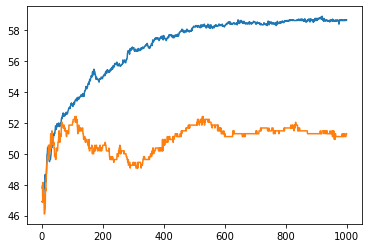

In [13]:
ep_li = sorted(list(set(ep_li)))
plt.plot(ep_li, acc_list)
plt.plot(ep_li, test_acc_list)
plt.show()

Here, we save training and testing data in csvs as well as saving the PyTorch model.

In [14]:
from google.colab import files
from google.colab import drive

#Here, we download the train/test data csvs
#files.download("csv_train.csv")
#files.download("csv_test.csv")

drive.mount('/content/gdrive')

#Uncomment to save the torch models to these locations.

#torch.save(model.state_dict(), '/content/gdrive/My Drive/SCAI ML Phases of Matter Implementation/model1.'+ str(test_acc_list[-1]) + '.pth')

Mounted at /content/gdrive
